# Classical ON/OFF analysis
This tutorial will demonstrate how to run a generic ON/OFF analysis assuming you have no model for your background and that your source is point-like. First we will run a stacked ON/OFF analysis, followed by a runwise ON/OFF analysis.

Recall that before this point we have already done the following:
* Generated an observation definition XML file from our list of runs
* Applied event selection to those events

In [1]:
# Import the standard moduals
import gammalib
import ctools
import cscripts

# Import matplotlib for visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Setup the example scripts directory for inspecting the results
import sys
import os
sys.path.append(os.environ['CTOOLS']+'/share/examples/python/')
from show_residuals import plot_residuals
from show_spectrum  import plot_spectrum
from show_butterfly import plot_butterfly

Here we define some parameters relating to the source under investigation and how how we want to bin the energy axis:

In [2]:
# Source coordinates
srcname  = 'Crab'
ra       = 83.633
dec      = 22.0145

# Energy binning
emin     = 0.16
emax     = 30.0
enumbins = 20
ebinalg  = 'LOG'

## Preparing the ON/OFF binned data (stacked analysis)
The next step is to bin the data for the signal (ON) and background (OFF) regions. This is done using the `csphagen` script:

In [3]:
# Define input/output files
obsfile  = 'resources/obs_selected.xml'     # Input observation file

# Setup the csphagen script
phagen  = cscripts.csphagen()
phagen['inobs']         = obsfile           
phagen['outobs']        = 'resources/obs_onoff_stacked.xml'
phagen['outmodel']      = 'resources/onoff_stacked_model.xml'
phagen['prefix']        = 'resources/onoff_stacked'
phagen['inmodel']       = 'NONE'            # assume that the source is pointlike
phagen['ebinalg']       = ebinalg           # Method for defining energy binning
phagen['emin']          = emin              # Minimum energy (TeV)
phagen['emax']          = emax              # Maximum energy (TeV)
phagen['enumbins']      = enumbins          # Number of energy bins
phagen['coordsys']      = 'CEL'             # Coord. system for analysis
phagen['ra']            = ra                # RA of ON region center
phagen['dec']           = dec               # Dec of ON region center
phagen['rad']           = 0.1               # Radius of ON region (degrees)
phagen['bkgmethod']     = 'REFLECTED'       # Reflected region analysis
phagen['use_model_bkg'] = False             # No model for the background
phagen['maxoffset']     = 1.6               # Maximum source offset for data file to be considered
phagen['stack']         = True              # Stack the data
phagen.execute()

# Peak at the results
print('OBSERVATIONS:\n', phagen.obs()[0], '\n')
print('MODEL:\n', phagen.obs().models())

OBSERVATIONS:
 === GCTAOnOffObservation ===
 Name ......................: 
 Identifier ................: 
 Instrument ................: VERITASOnOff
 Statistic .................: wstat
 Ontime ....................: 2181.4773196 s
 Livetime ..................: 2181.4773196 s
 Deadtime correction .......: 1
=== GPha ===
 Exposure ..................: 2181.4773196 s
 Number of bins ............: 20
 Energy range ..............: 160 GeV - 30 TeV
 Observation energy range ..: 149.623565673828 GeV - 33.49654296875 TeV
 Total number of counts ....: 287
 Underflow counts ..........: 5
 Overflow counts ...........: 1
 Outflow counts ............: 0
=== GPha ===
 Exposure ..................: 2181.4773196 s
 Number of bins ............: 20
 Energy range ..............: 160 GeV - 30 TeV
 Observation energy range ..: 149.623565673828 GeV - 33.49654296875 TeV
 Total number of counts ....: 143
 Underflow counts ..........: 6
 Overflow counts ...........: 0
 Outflow counts ............: 0
=== GArf ===


You should now have the files `obs_onoff.xml` and `onoff_model.xml` in the resources folder. These files define the counts information and source model that will be used and the ON/OFF analysis, respectively. Since we have not specified any input model the script has placed a point source, named Dummy, at the center of the On region with a power law spectrum. We will rename this source as Crab.

In [4]:
phagen.obs().models()['Dummy'].name(srcname)  # Rename source
phagen.obs().models()[srcname].tscalc(True)   # Compute a TS value

## Likelihood ON/OFF fit (stacked)
We can now quite easily run the ON/OFF analysis directly

In [5]:
# Run a likelihood analysis
like = ctools.ctlike(phagen.obs())
like['outmodel'] = 'resources/crab_onoff_stacked_plaw.xml'
like.execute()

# Look at the results
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 10.647
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 6
 Number of free parameters .: 2
 Number of iterations ......: 10
 Lambda ....................: 1e-07
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 6
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Test Statistic ............: 935.153029343876
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.633 deg (fixed,scale=1)
  DEC ......................: 22.0145 deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 3.46797767180737e-17 +/- 2.87330267840198e-18 [0,infty[ ph/cm2/s/MeV (free,scale=1e-18,gradient)
  I

Ok, not bad!

## Likelihood ON/OFF fit (un-stacked)
Now let's setup and run an un-stacked analysis

In [6]:
# Setup the csphagen script
phagen = cscripts.csphagen()
phagen['inobs']         = obsfile           
phagen['outobs']        = 'resources/obs_onoff_unstacked.xml'
phagen['outmodel']      = 'resources/onoff_unstacked_model.xml'
phagen['prefix']        = 'resources/onoff_unstacked'
phagen['inmodel']       = 'NONE'            # assume that the source is pointlike
phagen['ebinalg']       = ebinalg           # Method for defining energy bins
phagen['emin']          = emin              # Minimum energy (TeV)
phagen['emax']          = emax              # Maximum energy (TeV)
phagen['enumbins']      = enumbins          # Number of energy bins
phagen['coordsys']      = 'CEL'             # Coord. system for analysis
phagen['ra']            = ra                # RA of ON region center
phagen['dec']           = dec               # Dec of ON region center
phagen['rad']           = 0.1               # Radius of ON region (degrees)
phagen['bkgmethod']     = 'REFLECTED'       # Reflected region analysis
phagen['use_model_bkg'] = False             # No model for the background
phagen['maxoffset']     = 1.6               # Maximum source offset for data file to be considered
phagen['stack']         = False             # Dont stack the data
phagen.execute()

# Rename the source model
phagen.obs().models()['Dummy'].name(srcname)
phagen.obs().models()[srcname].tscalc(True)

In [7]:
# Run a likelihood analysis
like = ctools.ctlike(phagen.obs())
like['outmodel'] = 'resources/crab_onoff_unstacked_plaw.xml'
like.execute()

# Look at the results
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 22.216
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 6
 Number of free parameters .: 2
 Number of iterations ......: 12
 Lambda ....................: 1e-07
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 6
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Test Statistic ............: 938.723302565377
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.633 deg (fixed,scale=1)
  DEC ......................: 22.0145 deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 3.46199341563154e-17 +/- 2.88814269868207e-18 [0,infty[ ph/cm2/s/MeV (free,scale=1e-18,gradient)
  I

Again, the results seem reasonable! Let's take a look at the spectral residuals to see just how good we're doing.

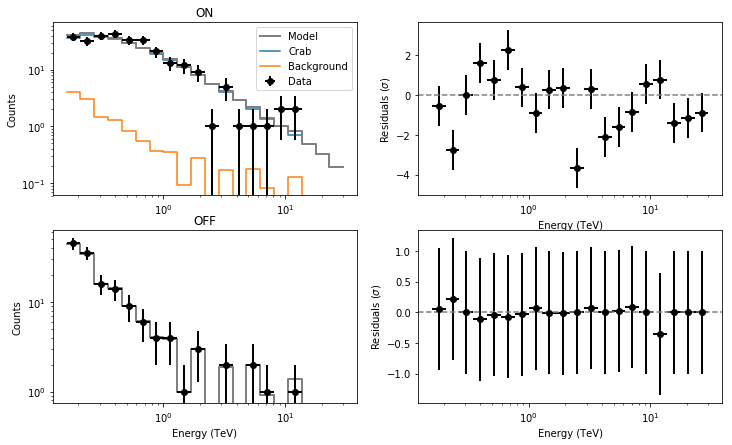

In [8]:
# Residuals output file
residuals = 'resources/residuals_crab_onoff_unstacked_plaw.fits'

# Generate the residuals
res = cscripts.csresspec(like.obs())
res['components'] = True
res['algorithm']  = 'SIGNIFICANCE'
res['outfile']    = residuals
res.execute()

# Now plot the residuals
plot_residuals(residuals,'',0)

## Log-parabola test
But we know the Crab is better modeled as a log-parabola, so let's apply that model to the data

In [9]:
# Create the desired spectral model
pref  = 3.4e-17
index = -2.4
pivot = gammalib.GEnergy(1.0, 'TeV')
curv  = -0.15
spectrum = gammalib.GModelSpectralLogParabola(pref, index, pivot, curv)

# Set the Crab spectrum
phagen.obs().models()[srcname].spectral(spectrum)

# Reinitialize and run the likelihood
like = ctools.ctlike(phagen.obs())
like['outmodel'] = 'resources/crab_onoff_unstacked_logparab.xml'
like.execute()

# Look at the results
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 20.362
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 7
 Number of free parameters .: 3
 Number of iterations ......: 3
 Lambda ....................: 1e-06
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 7
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Test Statistic ............: 942.431509434875
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "LogParabola" * "Constant"
 Number of parameters ......: 7
 Number of spatial par's ...: 2
  RA .......................: 83.633 deg (fixed,scale=1)
  DEC ......................: 22.0145 deg (fixed,scale=1)
 Number of spectral par's ..: 4
  Prefactor ................: 3.83272290722107e-17 +/- 3.70736095064603e-18 [0,infty[ ph/cm2/s/MeV (free,scale=3.4e-17,gradient)

Based on the value of the 'Test Statistic' the log-parabola model improved the fit, but not really by a significant amount. This isn't all that surprising, however, with only two runs.

Just for completeness, let's go ahead and re-generate the residuals for the log-parabola spectral model:

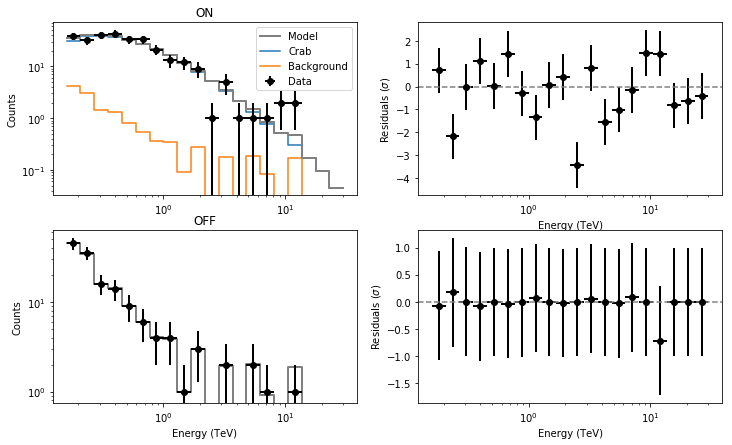

In [10]:
# Residuals output file
residuals = 'resources/residuals_crab_onoff_unstacked_logparab.fits'

# Run the script for generating the output file
res = cscripts.csresspec(like.obs())
res['components'] = True
res['algorithm']  = 'SIGNIFICANCE'
res['outfile']    = residuals
res.execute()

# Now use the 'plot_residuals' examples script to plot the residuals
plot_residuals(residuals,'',0)

# Butterfly Plot Generation
We can use `ctbutterfly` to generate a butterfly plot of the resulting spectrum.

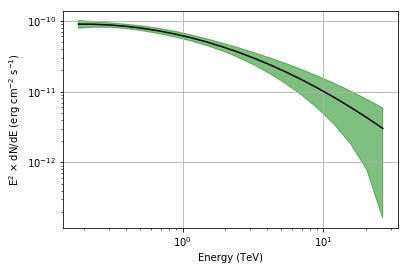

In [11]:
# Generate a butterfly plot
butterfly = ctools.ctbutterfly(like.obs())
butterfly['srcname']  = srcname
butterfly['edisp']    = True
butterfly['ebinalg']  = ebinalg
butterfly['enumbins'] = enumbins
butterfly['emin']     = emin
butterfly['emax']     = emax
butterfly['outfile']  = 'resources/crab_onoff_unstacked_logp_btrfly.fits'
butterfly.execute()

# Visualize the results
plot_butterfly(butterfly['outfile'].filename(), 'resources/crab_onoff_unstacked_logp_btrfly.png')

## SED Generation
So we've generated a spectral fit and visualized the spectrum, but we can also generate an SED using `csspec`.

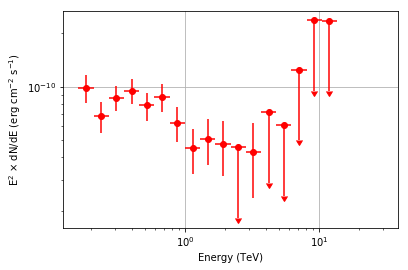

In [12]:
# Generate the spectral information
spec = cscripts.csspec(like.obs())
spec['srcname']  = srcname
spec['edisp']    = True
spec['ebinalg']  = ebinalg
spec['enumbins'] = enumbins
spec['emin']     = emin
spec['emax']     = emax
spec['method']   = 'AUTO'
spec['outfile']  = 'resources/crab_onoff_unstacked_logp_spec.fits'
spec.execute()

# Visualize the result
plot_spectrum(spec['outfile'].filename(), 'resources/crab_onoff_unstacked_logp_spec.png')

## Wrapup
You should now have at least an idea of how to run a standard analysis of DL3 formatted veritas data using ctools. In the next tutorial (veritas_ctools_classical_v2) you will see how to define exclusion regions. We will then see how to apply those exclusion regions in a fit and how to generate an RBM significance map.